In [1]:
import statistics
import pprint
import pandas as pd
import numpy as np
from random import uniform
from tslearn.utils import to_time_series_dataset
from tslearn.metrics import dtw#, gak
import plotly.express as px
import scipy.stats as st
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
import seaborn as sns; sns.set()
#ToDo: Threading

In [2]:
def get_best_distribution(data):
    
    dist_names = ["gamma", "gumbel_l", "cauchy", "dgamma", "beta", "betaprime", "exponweib", "rayleigh", "fisk",
                  "gausshyper", "invweibull", "pareto", "alpha", "expon", "hypsecant", "mielke", "loggamma",
                  "rdist", "rice"] ## Agregar más a voluntad
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)
        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value
    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    
    parms = params[best_dist]
    #print("Parameters for the best fit: "+ str(parms))
    
    map_parms = {}
    dist = getattr(st, best_dist)
    try:
        counter_wrong_chars = 0                                     #To solve a bug
        for position, shape_parameter in enumerate(dist.shapes):
            #print(position, shape_parameter)
            if shape_parameter not in [' ', ',']:
                map_parms[shape_parameter] = parms[position-counter_wrong_chars]
            else:
                counter_wrong_chars += 1
    except:
        pass
    finally:
        map_parms["loc"] = parms[-2]
        map_parms["scale"] = parms[-1]
    print("Parameters for the best fit: "+ str(map_parms))

    return best_dist, best_p, parms, map_parms

In [3]:
def get_optimal_curves(df_curves, example_curves, ts_example_curves, dict_probability_distrs, prob_distrs,
               min_count_generated_curves, a, b, E_min, min_f_load, roof_dtw_distance, min_corr):

    I = 5000                        #5000
    acum_generated_curves = 0

    while acum_generated_curves < min_count_generated_curves:
        for i in range(1,I+1):
            C_i = [None] * 24
            h_max = int(round(uniform(19, 21),0))
            C_i[h_max] = 1

            for h, none in enumerate(C_i):
                if h != h_max:
                    function = dict_probability_distrs[prob_distrs[h][0]]
                    parms = prob_distrs[h][1]
                    was_random_number_found = False
                    while was_random_number_found is False:
                        E = function.rvs(**parms, size=1)[0]
                        if (E>=E_min and E<1):
                            was_random_number_found = True
                    C_i[h] = E
            E_acum = sum(C_i)
            if (E_acum>=a and E_acum<=b):
                #print(C_i, type(C_i))
                f_load = statistics.mean(C_i) / max(C_i)
                if f_load >= min_f_load:
                    ts_C_i = to_time_series_dataset(C_i)[0]
                    dtw_distances = []

                    for k, curve in enumerate(ts_example_curves):
                        dtw_distance = dtw(ts_C_i, curve)
                        dtw_distances.append(dtw_distance)
                    average_dtw = statistics.mean(dtw_distances)
                    if average_dtw < roof_dtw_distance:
                        corrs = []

                        for example_curve in example_curves:
                            corr = np.corrcoef(C_i, example_curve)
                            corrs.append(corr[0][1])
                        average_corr = statistics.mean(corrs)
                        if average_corr>=min_corr:
                            print(i, f_load, E_acum, average_dtw, average_corr)
                            df_curves = df_curves.append(
                                    { '0': C_i[0], '1': C_i[1], '2': C_i[2],
                                     '3': C_i[3], '4': C_i[4], '5': C_i[5],
                                     '6': C_i[6], '7': C_i[7], '8': C_i[8],
                                     '9': C_i[9], '10': C_i[10], '11': C_i[11],
                                     '12': C_i[12], '13': C_i[13], '14': C_i[14],
                                     '15': C_i[15], '16': C_i[16], '17': C_i[17], 
                                     '18': C_i[18], '19': C_i[19], '20': C_i[20],
                                     '21': C_i[21], '22': C_i[22], '23': C_i[23],
                                     'FC': f_load, 'Sum': E_acum,
                                     'DTW_avg_distance': average_dtw, 'Avg_correlation': average_corr },
                                ignore_index=True
                            )
                            acum_generated_curves += 1
                            if acum_generated_curves>=min_count_generated_curves:
                                
                                return (df_curves)

In [4]:
df_example_curves = pd.read_excel (r'Curvas.xlsx')
df_example_curves.drop(
    df_example_curves.columns[
        df_example_curves.columns.str.contains('unnamed', case = False, na=False)
    ],
    axis = 1,
    inplace = True
)

a = df_example_curves['Sum'].min()
b = df_example_curves['Sum'].max()

df_example_curves = df_example_curves.drop(['FC', 'Sum', 'Comentario'], axis=1)

print("a: ", a, " b: ", b)
print(df_example_curves)

a:  15.161736140999999  b:  19.249227906976746
         0         1         2         3         4         5         6   \
0  0.465685  0.397058  0.367646  0.372548  0.382352  0.421568  0.568626   
1  0.637209  0.506977  0.469767  0.469767  0.488372  0.548837  0.725581   
2  0.637209  0.506977  0.469767  0.469767  0.488372  0.548837  0.705581   
3  0.617209  0.486977  0.449767  0.449767  0.468372  0.528837  0.685581   
4  0.589328  0.474497  0.439237  0.440463  0.456867  0.512020  0.671343   
5  0.539052  0.436891  0.403702  0.403582  0.420730  0.470823  0.621096   

         7         8         9   ...        14        15        16        17  \
0  0.622548  0.784315  0.779408  ...  0.647058  0.504901  0.495097  0.460784   
1  0.800000  0.990698  0.981395  ...  0.818605  0.865116  0.893023  0.734884   
2  0.800000  0.901320  0.891395  ...  0.818605  0.865116  0.893023  0.767884   
3  0.800000  0.901320  0.891395  ...  0.818605  0.865116  0.873023  0.747884   
4  0.755637  0.894413  0.88

In [5]:
prob_distrs = []
plots = []
for (columnName, columnData) in df_example_curves.iteritems():
    ## Maximizar el p-value ##
    print('Colunm Name : ', columnName)
    #print('Column Contents : ', columnData.values, type(columnData.values), columnData.values.shape)
    best_dist, best_p, parms, map_parms = get_best_distribution(columnData.values)
    prob_distrs.append([best_dist, map_parms])
    #if columnName == 12:
    #    ax = sns.distplot(columnData.values, kde=False)
    #ax = sns.distplot(columnData.values, kde=False)
print("prob_distrs: ")
pprint.pprint(prob_distrs)

Colunm Name :  0
p value for gamma = 0.9153858662603467
p value for gumbel_l = 0.9611650805916115
p value for cauchy = 0.5828338337557992
p value for dgamma = 0.7103295891934879
p value for beta = 0.4258226481275949
p value for betaprime = 0.9240764030877295


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:708: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:712: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for exponweib = 0.09960496852055273
p value for rayleigh = 0.6757859930739376
p value for fisk = 0.9528344588739082


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:3373: RuntimeWarning: divide by zero encountered in power
  return 1.0/Cinv * x**(a-1.0) * (1.0-x)**(b-1.0) / (1.0+z*x)**c


p value for gausshyper = 0.30576640871424515
p value for invweibull = 0.8417519047290813
p value for pareto = 0.5336665364053506
p value for alpha = 0.9067330652747674
p value for expon = 0.4587312555913199
p value for hypsecant = 0.9223079906180552
p value for mielke = 0.47566663473773685
p value for loggamma = 0.0037722908093278493


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


p value for rdist = 0.0
p value for rice = 0.9112020080835465
Best fitting distribution: gumbel_l
Best p value: 0.9611650805916115
Parameters for the best fit: {'loc': 0.6085684047258331, 'scale': 0.042804155481658675}
Colunm Name :  1
p value for gamma = 0.8889958053792573
p value for gumbel_l = 0.9646057727711407
p value for cauchy = 0.8261402488613532
p value for dgamma = 0.9029286229445405
p value for beta = 0.42576280633747704
p value for betaprime = 0.8990403693904233
p value for exponweib = 0.14434269055250448
p value for rayleigh = 0.6539560891521108
p value for fisk = 0.9763835373511555
p value for gausshyper = 0.4257544581462159
p value for invweibull = 0.8033963410294281
p value for pareto = 0.43577568017068163
p value for alpha = 0.8662969549571008
p value for expon = 0.438748236767811
p value for hypsecant = 0.9617653431217729
p value for mielke = 0.9338345346805417
p value for loggamma = 0.0037722908093278493
p value for rdist = 0.0
p value for rice = 0.8828955905498191
B

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:1608: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))


p value for exponweib = 0.03883655304054355
p value for rayleigh = 0.6362219194693021
p value for fisk = 0.81077888034992
p value for gausshyper = 0.06558641975271512
p value for invweibull = 0.8432989693608792
p value for pareto = 0.4909984342470688
p value for alpha = 0.6187465093875405
p value for expon = 0.46038765914758417
p value for hypsecant = 0.8010978605201914
p value for mielke = 0.08650095941200725
p value for loggamma = 0.06558641975308642
p value for rdist = 0.0
p value for rice = 0.6150327026762274
Best fitting distribution: invweibull
Best p value: 0.8432989693608792
Parameters for the best fit: {'c': 89762340.98886724, 'loc': -6418271.597604012, 'scale': 6418272.308923408}
Colunm Name :  8
p value for gamma = 0.8909274136772382
p value for gumbel_l = 0.5668489340967714
p value for cauchy = 0.8089051243416464
p value for dgamma = 0.4257526467691534
p value for beta = 0.2072037795466098
p value for betaprime = 0.902588161776341
p value for exponweib = 0.30383723296705595

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


p value for beta = 0.42575445968738856
p value for betaprime = 0.9340419420995283
p value for exponweib = 0.1912368964165128
p value for rayleigh = 0.686326276822022
p value for fisk = 0.9864105748028513
p value for gausshyper = 0.42575445815486407
p value for invweibull = 0.8237504309089143
p value for pareto = 0.4552939665002624
p value for alpha = 0.9020986421326999
p value for expon = 0.4531596049126275
p value for hypsecant = 0.994839115540973
p value for mielke = 0.6286174246263803
p value for loggamma = 0.0037722908093278493
p value for rdist = 0.0
p value for rice = 0.9050530696799255
Best fitting distribution: hypsecant
Best p value: 0.994839115540973
Parameters for the best fit: {'loc': 0.8937249916078858, 'scale': 0.049857587343792586}
Colunm Name :  11
p value for gamma = 0.6303708391173221
p value for gumbel_l = 0.47652857952026006
p value for cauchy = 0.06644746581252656
p value for dgamma = 0.44063818285977574
p value for beta = 0.06563832891444513
p value for betaprime 

p value for beta = 0.9770414499693317
p value for betaprime = 0.958820968010875
p value for exponweib = 0.057868731964175586
p value for rayleigh = 0.940404850100629
p value for fisk = 0.28887485288320547
p value for gausshyper = 0.0392041605139932
p value for invweibull = 0.9718769002363463
p value for pareto = 0.9466782426944375
p value for alpha = 0.9521724839190224
p value for expon = 0.9470509015881015
p value for hypsecant = 0.9623269532515218
p value for mielke = 0.9663380662901748
p value for loggamma = 0.9531845732660127
p value for rdist = 0.9952823413036828
p value for rice = 0.9388879901589855
Best fitting distribution: rdist
Best p value: 0.9952823413036828
Parameters for the best fit: {'c': 1.0609993438745944, 'loc': 0.9646594345073922, 'scale': 0.03891703450739226}
Colunm Name :  20
p value for gamma = 0.008100258685190079
p value for gumbel_l = 0.18311500709503842
p value for cauchy = 0.0677097913134959
p value for dgamma = 0.06558645565109904
p value for beta = 0.31653

In [6]:
dict_probability_distrs = { "gamma": st.gamma, "gumbel_l": st.gumbel_l, "cauchy": st.cauchy, "dgamma": st.dgamma,
                           "beta": st.beta, "betaprime": st.betaprime, "exponweib": st.exponweib, "rayleigh": st.rayleigh,
                           "fisk": st.fisk, "gausshyper": st.gausshyper, "invweibull": st.invweibull, "pareto": st.pareto,
                           "alpha": st.alpha, "expon": st.expon, "hypsecant": st.hypsecant, "mielke": st.mielke,
                           "loggamma": st.loggamma, "rdist": st.rdist, "rice": st.rice }

In [7]:
example_curves = df_example_curves.values.tolist()
ts_example_curves = to_time_series_dataset(example_curves)
#pprint.pprint(ts_example_curves)

In [8]:
df_curves = pd.DataFrame(
    columns=[
        '0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23',
        'FC','Sum','DTW_avg_distance','Avg_correlation'
    ]
)
print(df_curves)

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, FC, Sum, DTW_avg_distance, Avg_correlation]
Index: []

[0 rows x 28 columns]


In [9]:
E_min = 0.375
min_f_load = 0.7625
min_count_generated_curves = 25
roof_dtw_distance = 0.25        #0.25
min_corr = 0.95                 #0.95

df_curves = get_optimal_curves(df_curves, example_curves, ts_example_curves, dict_probability_distrs, prob_distrs,
                               min_count_generated_curves, a, b, E_min, min_f_load, roof_dtw_distance, min_corr)

171 0.7647251331973163 18.35340319673559 0.24503839754008055 0.961931004890237
3323 0.7643839578333489 18.34521498800037 0.24547113782050675 0.9546063977452295
3563 0.7688067637255614 18.451362329413477 0.24813106456230546 0.965695644938727
4503 0.765315690300572 18.367576567213728 0.24941423267433088 0.9575925135551389
4656 0.765117687890543 18.362824509373034 0.2465874505082063 0.950532602590968
303 0.7638784961744066 18.33308390818576 0.23952572194898983 0.959238945217764
1338 0.7636822787411582 18.328374689787797 0.24931849291311164 0.9608439128899408
2178 0.7644288616935668 18.346292680645604 0.24485351528679425 0.958688497511137
930 0.7625874552448444 18.302098925876262 0.2495956201062087 0.9525297815128697
1528 0.7665429814088554 18.397031553812532 0.24951533093937722 0.959438828470824
1975 0.7627562723310513 18.30615053594523 0.246796913882674 0.9597233601560198
2287 0.7635390850453465 18.324938041088316 0.24536118350853603 0.9683438606387573
3971 0.7641261700839537 18.33902808

In [10]:
print(df_curves)

           0         1         2         3         4         5         6  \
0   0.610331  0.434236  0.449072  0.401362  0.469460  0.527173  0.721520   
1   0.584646  0.446702  0.425810  0.459555  0.451049  0.591894  0.708186   
2   0.601119  0.486388  0.416625  0.486396  0.474938  0.542921  0.613405   
3   0.631015  0.481942  0.445273  0.430063  0.459355  0.515438  0.690438   
4   0.597480  0.468423  0.495378  0.478195  0.481154  0.464275  0.686589   
5   0.569603  0.464617  0.444821  0.425164  0.471543  0.528657  0.700729   
6   0.582364  0.488758  0.444639  0.411429  0.432149  0.587136  0.750045   
7   0.617605  0.498322  0.432600  0.459844  0.511347  0.508999  0.726855   
8   0.565926  0.485179  0.439380  0.405086  0.515203  0.525995  0.716504   
9   0.551098  0.507204  0.489339  0.437384  0.461882  0.560855  0.686293   
10  0.575701  0.505688  0.479513  0.435272  0.493991  0.500583  0.668671   
11  0.601050  0.461377  0.428182  0.426886  0.446890  0.503203  0.701188   
12  0.567889

In [1]:
for index, row in df_curves.loc[:, "0":"23"].iterrows():
    fig = px.line(row, width=600, height=300, xlabel='Hora')
    fig.show()

NameError: name 'df_curves' is not defined

In [12]:
average_optimal_curve = df_curves.loc[:, "0":"23"].mean(axis=0)

print(average_optimal_curve, type(average_optimal_curve))

0     0.588730
1     0.483821
2     0.448402
3     0.447502
4     0.476817
5     0.530553
6     0.699839
7     0.791792
8     0.891977
9     0.882838
10    0.892188
11    0.902291
12    0.885800
13    0.872095
14    0.822360
15    0.818517
16    0.811809
17    0.729538
18    0.725478
19    0.976659
20    0.996382
21    0.982437
22    0.936843
23    0.766819
dtype: float64 <class 'pandas.core.series.Series'>
Load Factor: 


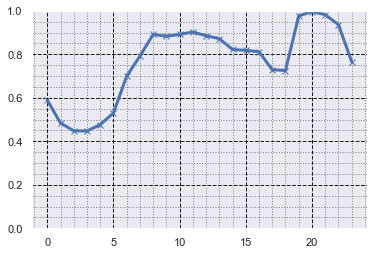

final_load_factor:  0.7678401436126037
final_energy_sum:  18.36148530228425


In [47]:
average_optimal_curve.plot(linewidth=3.0, marker='x', ms=6.5)
plt.axis((None,None,0,1))
plt.grid(b=True, which='major', color='k', linestyle='--')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='grey', linestyle=':')
plt.show()

final_load_factor = average_optimal_curve.mean() / average_optimal_curve.max()
print("final_load_factor: ", final_load_factor)

final_energy_sum = average_optimal_curve.sum()
print("final_energy_sum: ", final_energy_sum)